In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import signal
from matplotlib import cm, colors
from matplotlib.patches import Circle
import cartopy as ca
import cartopy.crs as ccrs

# Set font sizes for plots
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=MEDIUM_SIZE)

# Global warming levels
Tglob = ["T0","T15","T27"]
Tglob_values = [0,1.5,2.7]

# Data path
data_path = '/work/uo1075/u241297/data/large_ensembles/CMIP6/ACCESS-ESM1-5/'

# Global warming levels

In [2]:
path=data_path+'global-mean/'

# Load global-mean surface air temperature (GSAT) data
GSAT = np.zeros((40,251))
for i in range(40):
    file = path + "tas_hist_ssp585_r" + str(i + 1)+"_global-mean.nc"
    GSAT[i,:] = np.squeeze(xr.open_dataset(file)['tas']) - 273.15
    
GSAT_rm = np.array(pd.DataFrame(GSAT).rolling(20, axis=1, center=True).mean())
Tzero_GSAT = np.mean(GSAT[:,0:51]) #1850-1900
GSATa = GSAT - Tzero_GSAT
GSATa_rm = GSAT_rm - Tzero_GSAT

In [3]:
# Determine the indices where GSAT crosses the global warming levels
GWLcross_ind = {T: np.empty(40, dtype=int) for T in Tglob}
GWLcross_ind["T0"] = 40 * [20]

for T in range(1, 3):
    for i in range(40):
        j = 20
        while GSATa_rm[i, j] < Tglob_values[T]:
            j += 1
        GWLcross_ind[Tglob[T]][i] = j

GWL_ind = {T: np.zeros((40, 20), dtype=int) for T in Tglob}

for T in range(3):
    for i in range(40):
        GWL_ind[Tglob[T]][i, :] = np.arange(GWLcross_ind[Tglob[T]][i] - 10, GWLcross_ind[Tglob[T]][i] + 10)

# Daily, spatial temperatures

In [4]:
path=data_path+'greenland/'

# Read daily SAT data
SATday = np.zeros((40,251,365,29,43))
for i in range(40):
    file = path+"tas_hist_ssp585_r"+str(i+1)+"_greenland.nc"
    SATday[i,:,:]=np.array(xr.open_dataset(file)['tas']).reshape((251,365,29,43))-273.15

# Create GWL samples
SATday_samples = {Tglob[T]: [SATday[i, GWL_ind[Tglob[T]][i, :],:,:,:] for i in range(40)] for T in range(3)}

# Clean up memory
del SATday

In [5]:
# Detrend by subtracting linear trend of ensemble mean

# Ensemble mean
SATday_ensmean_samples = {
    T: np.nan_to_num(np.mean(SATday_samples[T], axis=0))
    for T in Tglob
}

# Daily trend
SATday_trend_samples = {
    T: SATday_ensmean_samples[T] - signal.detrend(SATday_ensmean_samples[T], axis=0) - np.mean(SATday_ensmean_samples[T], axis=0, keepdims=True)
    for T in Tglob
}

# Daily detrended
SATday_detrend_samples = {
    T: SATday_samples[T] - SATday_trend_samples[T][np.newaxis, :, :, :, :]
    for T in Tglob
}

# Compute melt days and melt area

In [6]:
# Compute the number of melt days with SAT > 0°C per year for every grid cell and ensemble member
meltdays = {T: np.count_nonzero(SATday_detrend_samples[T] > 0, axis=2) for T in Tglob}

# Read grid cell area
gridarea = np.array(xr.open_dataset(data_path + 'greenland/gridarea_greenland.nc')['cell_area'])

# Greenland area
GRL_area = np.sum(gridarea[~np.isnan(SATday_detrend_samples['T0'][0,0,0,:,:])]/1e12)

# Compute the area that experiences more than 0,1,...,100 melt days and the residual Greenland area (= nonmelt_area_gradual)
nonmelt_area_gradual = {}
for T in Tglob:
    mean_meltdays = np.mean(meltdays[T], axis=(0, 1))
    nonmelt_area_gradual[T] = np.array([
        GRL_area - np.nansum(gridarea[mean_meltdays > i]) / 1e12
        for i in range(100)
    ])

In [7]:
#gradual melt area
nonmelt_area_gradual = dict()
for Ti in range(3):
    nonmelt_area_gradual[Tglob[Ti]] = np.zeros((100))
    for i in range(100):
        nonmelt_area_gradual[Tglob[Ti]][i] = GRL_area - np.sum(gridarea[np.mean(meltdays[Tglob[Ti]],axis=(0,1))>i]/1e12)

# Plots

## Maps

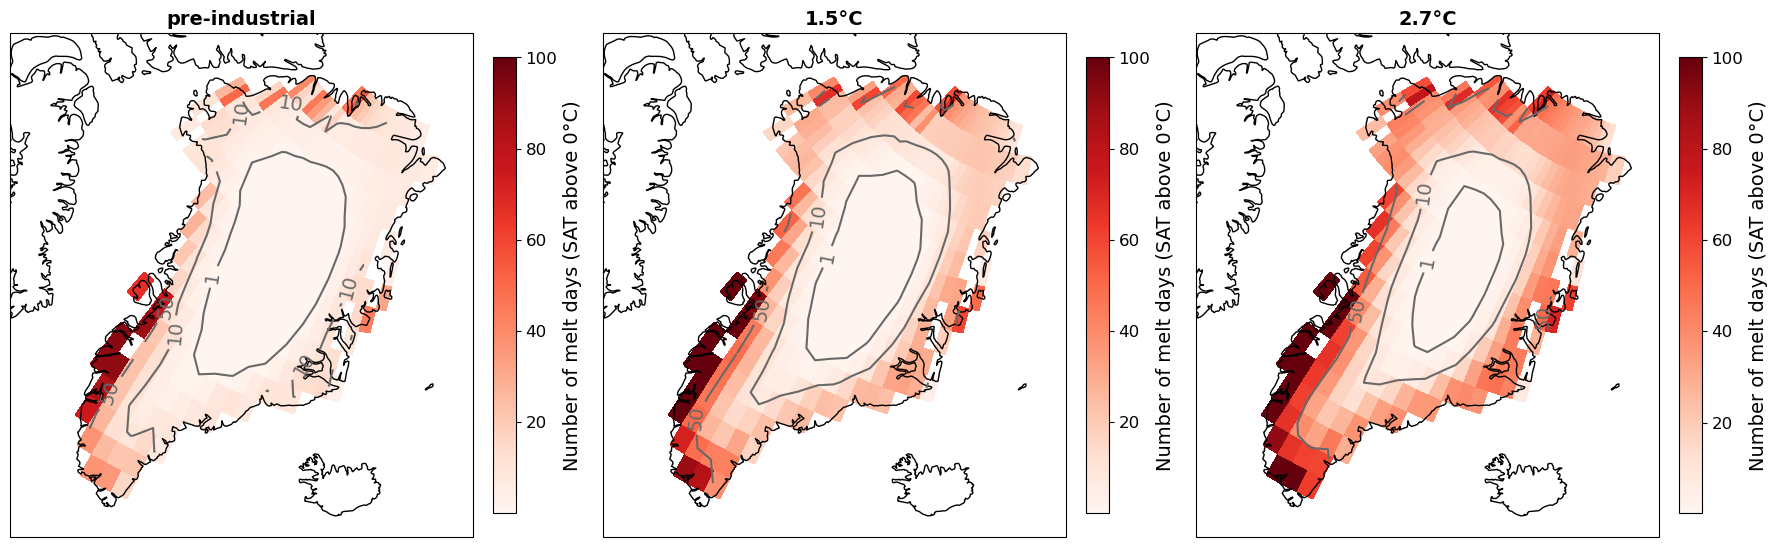

In [8]:
# Load lat and lon
file=data_path+"greenland/tas_hist_ssp585_r1_greenland.nc"
lon=np.array(xr.open_dataset(file)['lon'])
lat=np.array(xr.open_dataset(file)['lat'])

# Ensemble mean meltdays for plotting
meltdays_map = {T: np.mean(meltdays[T], axis=(0, 1)) for T in Tglob}
for T in Tglob:
    meltdays_map[T][np.isnan(SATday_detrend_samples[T][0, 0, 0, :, :])] = np.nan

data_crs = ccrs.PlateCarree()

# Plotting function
def plot_melt_map(ax, data, title):
    im = ax.pcolormesh(lon, lat, data, transform=data_crs, cmap='Reds', vmax=100)
    cs = ax.contour(lon, lat, data, levels=[0, 1, 10, 50], transform=data_crs, colors='dimgray')
    ax.clabel(cs)
    ax.coastlines()
    ax.set_extent((-60, -5, 63, 85))
    cbar = plt.colorbar(im, ax=ax, fraction=0.045, pad=0.04)
    cbar.set_label('Number of melt days (SAT above 0°C)')
    ax.set_title(title, fontweight='bold')

# Create plot
plt.figure(figsize=(18, 10))

titles = ['pre-industrial', '1.5°C', '2.7°C']
for idx, (key, title) in enumerate(zip(Tglob, titles)):
    ax = plt.subplot(1, 3, idx + 1, projection=ccrs.Stereographic())
    plot_melt_map(ax, meltdays_map[key], title)

plt.tight_layout()
plt.show()

## Circle plots

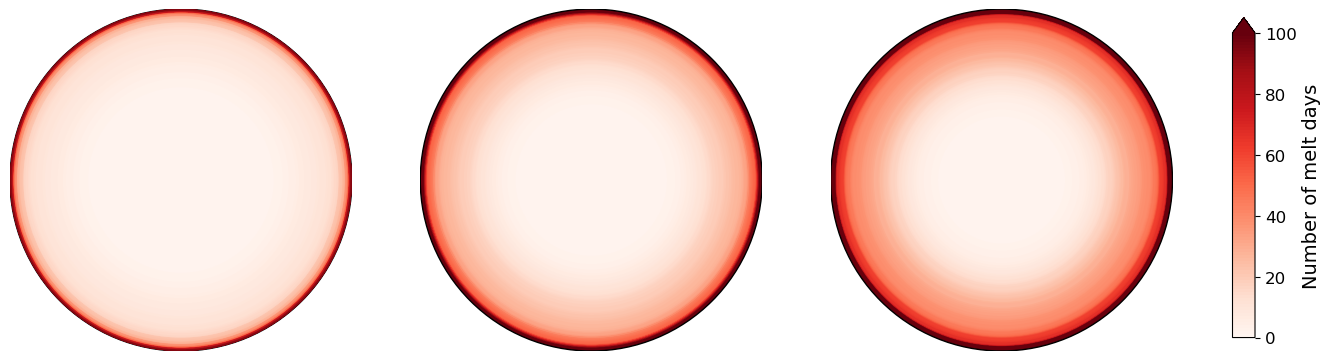

In [9]:
# Constants
center = (0.5, 0.5)
radius_GRL = 0.5

# Load the colormap
cmap = cm.get_cmap('Reds',100)

# Create subplots
fig, ax = plt.subplots(1,3,figsize=(15,5))

# Loop over the three GWLs
for T in range(3):
    # Draw outer circle
    circle_GRL = Circle(center, radius_GRL, fc=cmap(0.99), ec='k')
    ax[T].add_patch(circle_GRL)

    # Draw melt area circles
    for i in range(99,-1,-1):
        radius_nonmeltarea = radius_GRL * math.sqrt(nonmelt_area_gradual[Tglob[T]][i] / GRL_area)
        circle_nonmeltarea = Circle(center, radius_nonmeltarea, fc=cmap(i/100))
        ax[T].add_patch(circle_nonmeltarea)
    
    ax[T].set_aspect('equal')
    ax[T].axis('off')

# Add a colorbar
cax = fig.add_axes([0.94, 0.18, 0.015, 0.64])
norm = colors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, extend='max')
cbar.set_label('Number of melt days')

plt.show()

# NSIDC Greenland cumulative melt days (for comparison)

In [10]:
data_path = '/work/uo1227/u241297/GWL-analyses/data/Greenland_cumulative_melt/'

meltdays_nsidc = np.zeros((45,617,2496))
for i in range(45):
    year = 1979+i
    file = data_path+'greenland_cumulative_melt_'+str(year)+'.nc'
    meltdays_nsidc[i,:,:]=np.squeeze(xr.open_dataset(file)['Band1'])

lon_nsidc = np.array(xr.open_dataset(file)['lon'])
lat_nsidc = np.array(xr.open_dataset(file)['lat'])

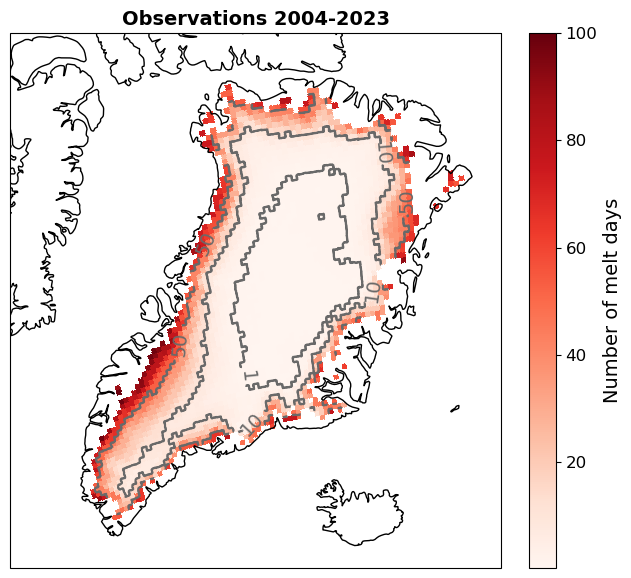

In [11]:
plt.figure(figsize=(8,6))

ax1 = plt.subplot(1,1,1,projection=ccrs.Stereographic())
im = plt.pcolormesh(lon_nsidc, lat_nsidc, np.mean(meltdays_nsidc[-20:,:,:],axis=0), transform = data_crs,cmap='Reds',vmax=100)
cs = plt.contour(lon_nsidc,lat_nsidc,np.mean(meltdays_nsidc[-20:,:,:],axis=0),levels=[0,1,10,50],transform=data_crs,colors='dimgray')
ax1.clabel(cs)
ax1.coastlines()
ax1.set_extent((-60, -5, 63, 85))
cbar = plt.colorbar(im,fraction=0.045, pad=0.04)
cbar.set_label('Number of melt days')
ax1.set_title('Observations 2004-2023',fontweight='bold')

plt.tight_layout()
plt.show()